https://www.kaggle.com/code/meenaaa/cancer-death-rate-xgboost/notebook

https://www.researchgate.net/publication/341042405_On_linear_regression_models_with_hierarchical_categorical_variables

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# data wrangling tools
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# statistical analysis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# scikit-learn
from sklearn.model_selection import train_test_split

import time

In [4]:
import numpy as np
import pandas as pd
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour
import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.layers import *
# from tensorflow.keras import *
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.callbacks import LearningRateScheduler
# from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from pickle import load

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
trainset = pd.read_csv("/content/drive/My Drive/DataMining/POC/LungCancer/Dataset/Raw/trainset.csv", index_col = 0)
trainset.head(5)

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,...,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,City,State,Region,Division,TARGET_deathRate
Geography,,,,,,,,,,,,,,,,,,,,,
"Greene County, North Carolina",105.0,43.000,440.800000,37263,21134.000,28.3,0.000000,0,39.00,37.0,...,24.785427,0.150038,5.051674,43.921351,8.353222,603,33,2,6,183.2
"McHenry County, Illinois",1192.5,329.875,474.400000,72741,153227.875,6.9,0.000000,8,39.30,38.2,...,1.345992,2.633745,2.641228,61.798687,4.286142,948,13,0,0,181.4
"Wichita County, Kansas",1192.5,6.000,453.549422,53447,2157.000,11.5,0.000000,6,35.70,34.5,...,0.000000,0.317604,2.903811,57.490397,7.061503,1614,16,0,7,177.6
"Mineral County, Montana",35.0,12.000,538.800000,36449,4251.000,17.3,0.000000,0,53.55,51.9,...,0.070788,0.165172,0.141576,46.769034,3.333333,984,26,3,3,188.8
"Ohio County, West Virginia",308.0,123.000,500.900000,40195,43066.000,18.4,209.768024,1,43.30,41.3,...,4.152439,0.850196,0.288746,42.926988,3.257227,1085,48,2,6,184.4


In [7]:
valset = pd.read_csv("/content/drive/My Drive/DataMining/POC/LungCancer/Dataset/Raw/valset.csv", index_col = 0)
valset.head(5)

,avgAnnCount,avgDeathsPerYear,incidenceRate,medIncome,popEst2015,povertyPercent,studyPerCap,binnedInc,MedianAge,MedianAgeMale,...,PctBlack,PctAsian,PctOtherRace,PctMarriedHouseholds,BirthRate,TARGET_deathRate,City,State,Region,Division
Geography,,,,,,,,,,,,,,,,,,,,,
"Linn County, Oregon",675.0,273,477.4,44358,120547.0,19.1,8.295520,3,39.50,38.8,...,0.437922,1.223828,1.237276,51.807095,4.659173,186.5,139,32,3,5
"Champaign County, Illinois",781.0,267,450.2,47966,169831.5,22.6,201.766857,4,29.30,28.2,...,12.588086,2.628022,0.978296,39.728702,3.467191,152.5,40,8,0,0
"Saratoga County, New York",1113.5,354,508.7,71885,169831.5,7.2,26.519454,8,41.80,40.9,...,1.611447,2.372930,0.393254,52.770765,4.520914,174.2,228,27,1,2
"Montmorency County, Michigan",88.0,37,484.4,37961,9259.0,15.7,0.000000,1,52.35,50.7,...,0.361664,0.000000,0.340389,49.213759,3.263086,207.6,172,17,0,0
"Barrow County, Georgia",281.0,114,457.7,49698,75370.0,13.0,0.000000,5,34.80,32.9,...,11.578626,2.628022,1.976060,55.195246,5.318187,192.0,8,6,2,6


In [8]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2467 entries, Greene County, North Carolina to Van Wert County, Ohio
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avgAnnCount              2467 non-null   float64
 1   avgDeathsPerYear         2467 non-null   float64
 2   incidenceRate            2467 non-null   float64
 3   medIncome                2467 non-null   int64  
 4   popEst2015               2467 non-null   float64
 5   povertyPercent           2467 non-null   float64
 6   studyPerCap              2467 non-null   float64
 7   binnedInc                2467 non-null   int64  
 8   MedianAge                2467 non-null   float64
 9   MedianAgeMale            2467 non-null   float64
 10  MedianAgeFemale          2467 non-null   float64
 11  AvgHouseholdSize         2467 non-null   float64
 12  PercentMarried           2467 non-null   float64
 13  PctNoHS18_24             2467 non-null

In [9]:
valset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, Linn County, Oregon to Macon County, Missouri
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avgAnnCount              305 non-null    float64
 1   avgDeathsPerYear         305 non-null    int64  
 2   incidenceRate            305 non-null    float64
 3   medIncome                305 non-null    int64  
 4   popEst2015               305 non-null    float64
 5   povertyPercent           305 non-null    float64
 6   studyPerCap              305 non-null    float64
 7   binnedInc                305 non-null    int64  
 8   MedianAge                305 non-null    float64
 9   MedianAgeMale            305 non-null    float64
 10  MedianAgeFemale          305 non-null    float64
 11  AvgHouseholdSize         305 non-null    float64
 12  PercentMarried           305 non-null    float64
 13  PctNoHS18_24             305 non-null    float64

In [10]:
X_train = trainset.drop(['TARGET_deathRate'], axis = 1)
y_train = trainset['TARGET_deathRate']

In [11]:
X_val = valset.drop(['TARGET_deathRate'], axis = 1)
y_val = valset['TARGET_deathRate']

In [12]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2467, 36) (2467,)
(305, 36) (305,)


In [13]:
import pickle
rfe_filename = '/content/drive/My Drive/DataMining/POC/LungCancer/FeatureSelection/Raw/raw_rfe.h5'
rfe_fit = pickle.load(open(rfe_filename, 'rb'))

In [14]:
X_train_rfe = rfe_fit.transform(X_train)
X_val_rfe = rfe_fit.transform(X_val)
print(X_train_rfe.shape, y_train.shape)
print(X_val_rfe.shape, y_val.shape)

(2467, 18) (2467,)
(305, 18) (305,)


# Measure

In [15]:
#evaluation metrics for regression model
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error, r2_score

In [16]:
def deviation_function(y_val, pred):
  deviation = []
  for i in range(0, len(y_val)):
    deviation.append(abs(pred[i] - y_val[i]) / y_val[i])
  return np.array(deviation).mean()

# Linear Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [17]:
#linear regression model
import optuna
from sklearn.linear_model import LinearRegression 
import sklearn.model_selection
#Grid search model
# from sklearn.model_selection import GridSearchCV         

In [18]:
def LR_Model(trial):
  fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
  copy_X = trial.suggest_categorical('copy_X', [True, False])
  lr = LinearRegression(copy_X = copy_X, fit_intercept = fit_intercept)
  score = sklearn.model_selection.cross_val_score(lr, X_train_rfe, y_train, cv=3)
  accuracy = score.mean()
  return accuracy

In [19]:
lr_study = optuna.create_study(direction="maximize")
lr_study.optimize(LR_Model, n_trials=4)
print(lr_study.best_trial)

[I 2023-05-10 01:50:38,223] A new study created in memory with name: no-name-1397a47b-c7fc-4af6-a1e3-7563f8391cfa
[I 2023-05-10 01:50:38,288] Trial 0 finished with value: 0.5100653705253054 and parameters: {'fit_intercept': False, 'copy_X': False}. Best is trial 0 with value: 0.5100653705253054.
[I 2023-05-10 01:50:38,384] Trial 1 finished with value: 0.524870719381501 and parameters: {'fit_intercept': True, 'copy_X': True}. Best is trial 1 with value: 0.524870719381501.
[I 2023-05-10 01:50:38,457] Trial 2 finished with value: 0.524870719381501 and parameters: {'fit_intercept': True, 'copy_X': False}. Best is trial 1 with value: 0.524870719381501.
[I 2023-05-10 01:50:38,517] Trial 3 finished with value: 0.5100653705253054 and parameters: {'fit_intercept': False, 'copy_X': True}. Best is trial 1 with value: 0.524870719381501.


FrozenTrial(number=1, state=TrialState.COMPLETE, values=[0.524870719381501], datetime_start=datetime.datetime(2023, 5, 10, 1, 50, 38, 292835), datetime_complete=datetime.datetime(2023, 5, 10, 1, 50, 38, 384202), params={'fit_intercept': True, 'copy_X': True}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'fit_intercept': CategoricalDistribution(choices=(True, False)), 'copy_X': CategoricalDistribution(choices=(True, False))}, trial_id=1, value=None)


In [20]:
plot_optimization_history(lr_study)

In [21]:
lr_study.best_trial.params

{'fit_intercept': True, 'copy_X': True}

https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file

In [22]:
np.save(f"/content/drive/My Drive/DataMining/POC/LungCancer/Parameter/Raw/lr_parameter.npy", lr_study.best_trial.params)

In [23]:
lr = LinearRegression(**lr_study.best_trial.params)


In [24]:
#training the model
lr_model = lr.fit(X_train_rfe,y_train) 
lr_pred = lr_model.predict(X_val_rfe)

## Evaluate

In [25]:
#evaluating the model with the following metrics
#mean squared error
lr_mse=mean_squared_error(lr_pred, y_val)     
#mean absolute error     
lr_mae=mean_absolute_error(lr_pred, y_val)  
#root mean squared error      
lr_rmse=np.sqrt(mean_squared_error(lr_pred, y_val))
#r2 score
lr_r2 = r2_score(lr_pred, y_val)
print(f'mse: {lr_mse}')
print(f'mae: {lr_mae}')
print(f'rmse: {lr_rmse}')
print(f"R-Squared: {lr_r2}")

mse: 333.8865742210965
mae: 13.991825774141407
rmse: 18.272563427748622
R-Squared: 0.3278388611783014


In [26]:
lr_df =pd.DataFrame({"mse": lr_mse,"mae": lr_mae,"rmse": lr_rmse, "r2": lr_r2, "deviation": deviation_function(y_val, lr_pred)},index=['Linear Regression'])

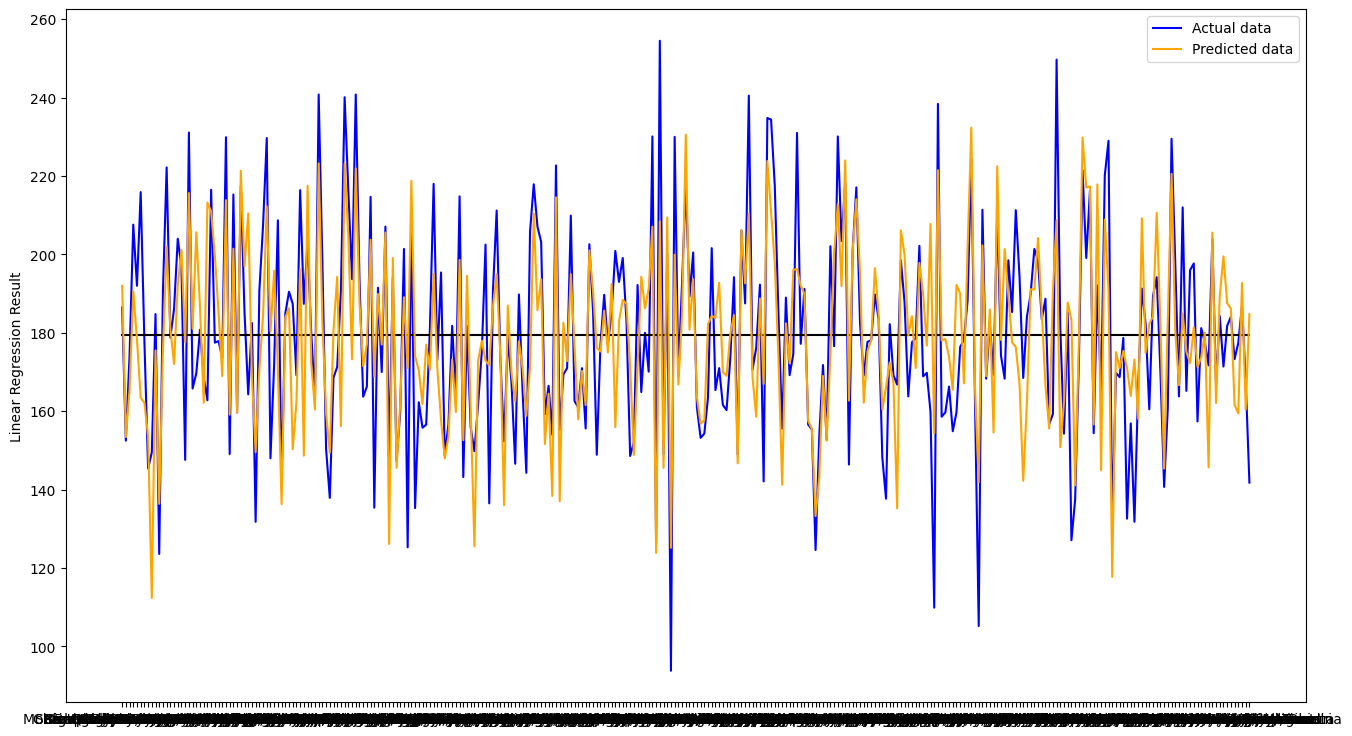

In [27]:
Axis = [y_val.mean()] * len(y_val)
plt.figure(figsize=(16, 9))
plt.ylabel('Linear Regression Result')
plt.plot(y_val, 'blue', label='Actual data')
plt.plot(Axis, color="black")
plt.plot(lr_pred, 'orange', label='Predicted data')
plt.legend()

# Decision Tree Regression

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [28]:
# decision tree regression model
from sklearn.tree import DecisionTreeRegressor             

In [29]:
def DTR_Model(trial):
  criterion = trial.suggest_categorical('criterion', ["squared_error", "friedman_mse", "absolute_error", "poisson"])
  splitter = trial.suggest_categorical('splitter', ["best", "random"])
  max_features = trial.suggest_categorical('max_features', ["auto", "sqrt", "log2", None])
  dtr = DecisionTreeRegressor(criterion=criterion, max_features = max_features, splitter = splitter)
  
  score = sklearn.model_selection.cross_val_score(dtr, X_train_rfe, y_train, cv=3)
  accuracy = score.mean()
  return accuracy

In [30]:
dtr_study = optuna.create_study(direction="maximize")
dtr_study.optimize(DTR_Model, n_trials=32)
print(dtr_study.best_trial)

[I 2023-05-10 01:50:45,979] A new study created in memory with name: no-name-cb3faf2e-ea8b-4b87-950b-51c5f097fb0d
[I 2023-05-10 01:50:46,172] Trial 0 finished with value: -0.0015470145184898199 and parameters: {'criterion': 'poisson', 'splitter': 'best', 'max_features': 'log2'}. Best is trial 0 with value: -0.0015470145184898199.
[I 2023-05-10 01:50:48,825] Trial 1 finished with value: 0.003162006420431703 and parameters: {'criterion': 'absolute_error', 'splitter': 'best', 'max_features': 'auto'}. Best is trial 1 with value: 0.003162006420431703.
[I 2023-05-10 01:50:48,888] Trial 2 finished with value: -0.027160173559891088 and parameters: {'criterion': 'poisson', 'splitter': 'random', 'max_features': 'auto'}. Best is trial 1 with value: 0.003162006420431703.
[I 2023-05-10 01:50:49,374] Trial 3 finished with value: -0.011141234464169666 and parameters: {'criterion': 'absolute_error', 'splitter': 'best', 'max_features': 'sqrt'}. Best is trial 1 with value: 0.003162006420431703.
[I 2023-

FrozenTrial(number=11, state=TrialState.COMPLETE, values=[0.10693135864772618], datetime_start=datetime.datetime(2023, 5, 10, 1, 50, 51, 5326), datetime_complete=datetime.datetime(2023, 5, 10, 1, 50, 51, 209077), params={'criterion': 'poisson', 'splitter': 'best', 'max_features': None}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'criterion': CategoricalDistribution(choices=('squared_error', 'friedman_mse', 'absolute_error', 'poisson')), 'splitter': CategoricalDistribution(choices=('best', 'random')), 'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2', None))}, trial_id=11, value=None)


In [31]:
plot_optimization_history(dtr_study)

In [32]:
dtr_study.best_trial.params

{'criterion': 'poisson', 'splitter': 'best', 'max_features': None}

https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file

In [33]:
np.save(f"/content/drive/My Drive/DataMining/POC/LungCancer/FeatureSelection/Raw/dtr_parameter.npy", dtr_study.best_trial.params)

In [34]:
dtr = DecisionTreeRegressor(**dtr_study.best_trial.params)

In [35]:
#training the model
dtr_model = dtr.fit(X_train_rfe,y_train) 
dtr_pred = dtr_model.predict(X_val_rfe)

## Evaluate

In [36]:
#evaluating the model with the following metrics
#mean squared error
dtr_mse=mean_squared_error(dtr_pred, y_val)     
#mean absolute error     
dtr_mae=mean_absolute_error(dtr_pred, y_val)  
#root mean squared error      
dtr_rmse=np.sqrt(mean_squared_error(dtr_pred, y_val))
#r2 score
dtr_r2 = r2_score(dtr_pred, y_val)
print(f'mse: {dtr_mse}')
print(f'mae: {dtr_mae}')
print(f'rmse: {dtr_rmse}')
print(f"r2_score: {dtr_r2}")

mse: 747.0800655737705
mae: 20.746885245901638
rmse: 27.33276542126264
r2_score: 0.1342382385090245


In [37]:
dtr_df =pd.DataFrame({"mse": dtr_mse,"mae": dtr_mae,"rmse": dtr_rmse, "r2": dtr_r2, "deviation": deviation_function(y_val, dtr_pred)},index=['Decision Tree Regression'])

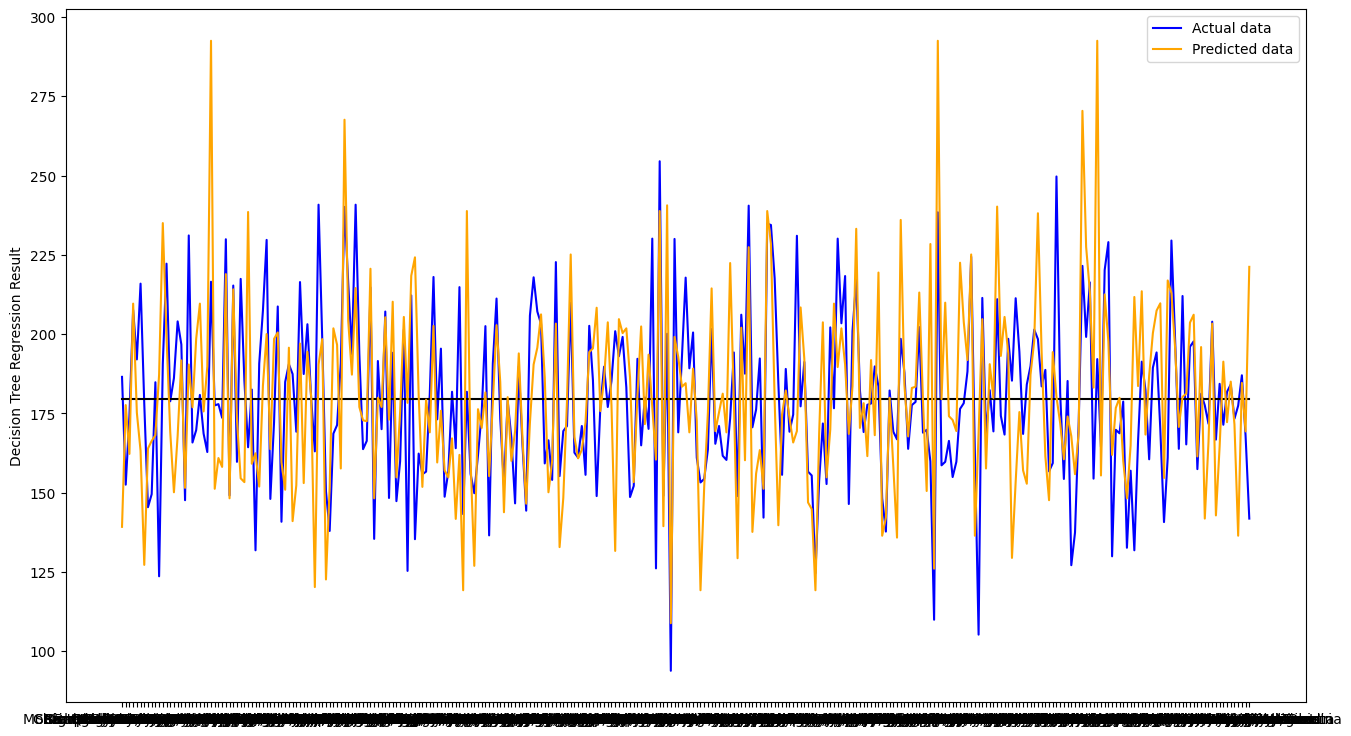

In [38]:
Axis = [y_val.mean()] * len(y_val)
plt.figure(figsize=(16, 9))
plt.ylabel('Decision Tree Regression Result')
plt.plot(y_val, 'blue', label='Actual data')
plt.plot(Axis, color="black")
plt.plot(dtr_pred, 'orange', label='Predicted data')
plt.legend()

# Random Forest Regression

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [39]:
# random forest regression model
from sklearn.ensemble import RandomForestRegressor             

In [40]:
def RFR_Model(trial):
  criterion = trial.suggest_categorical('criterion', ["squared_error", "friedman_mse", "absolute_error", "poisson"])
  max_features = trial.suggest_categorical('max_features', [1, "sqrt", "log2", None])
  rfr = RandomForestRegressor(criterion=criterion, max_features = max_features)
  
  score = sklearn.model_selection.cross_val_score(rfr, X_train_rfe, y_train, cv=3)
  accuracy = score.mean()
  return accuracy

In [41]:
rfr_study = optuna.create_study(direction="maximize")
rfr_study.optimize(RFR_Model, n_trials=16)
print(rfr_study.best_trial)

[I 2023-05-10 01:51:04,808] A new study created in memory with name: no-name-3b3a0f9c-2a82-4ae7-ad83-f3c512220a36
[I 2023-05-10 01:51:06,418] Trial 0 finished with value: 0.49036853608897363 and parameters: {'criterion': 'squared_error', 'max_features': 1}. Best is trial 0 with value: 0.49036853608897363.
[I 2023-05-10 01:51:12,863] Trial 1 finished with value: 0.5462798190887846 and parameters: {'criterion': 'friedman_mse', 'max_features': None}. Best is trial 1 with value: 0.5462798190887846.
[I 2023-05-10 01:51:15,950] Trial 2 finished with value: 0.5353599373531849 and parameters: {'criterion': 'squared_error', 'max_features': 'log2'}. Best is trial 1 with value: 0.5462798190887846.
[I 2023-05-10 01:51:19,035] Trial 3 finished with value: 0.5398954805560084 and parameters: {'criterion': 'poisson', 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5462798190887846.
[I 2023-05-10 01:51:21,137] Trial 4 finished with value: 0.5377671450331379 and parameters: {'criterion': 'friedma

FrozenTrial(number=8, state=TrialState.COMPLETE, values=[0.5512221418520366], datetime_start=datetime.datetime(2023, 5, 10, 1, 52, 32, 197434), datetime_complete=datetime.datetime(2023, 5, 10, 1, 52, 38, 492032), params={'criterion': 'squared_error', 'max_features': None}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'criterion': CategoricalDistribution(choices=('squared_error', 'friedman_mse', 'absolute_error', 'poisson')), 'max_features': CategoricalDistribution(choices=(1, 'sqrt', 'log2', None))}, trial_id=8, value=None)


In [42]:
plot_optimization_history(rfr_study)

In [43]:
rfr_study.best_trial.params

{'criterion': 'squared_error', 'max_features': None}

In [44]:
np.save(f"/content/drive/My Drive/DataMining/POC/LungCancer/FeatureSelection/Raw/rfr_parameter.npy", rfr_study.best_trial.params)

https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file

In [45]:
rfr = RandomForestRegressor(**rfr_study.best_trial.params)

In [46]:
#training the model
rfr_model = rfr.fit(X_train_rfe,y_train) 
rfr_pred = rfr_model.predict(X_val_rfe)

## Evaluate

In [47]:
#evaluating the model with the following metrics
#mean squared error
rfr_mse=mean_squared_error(rfr_pred, y_val)     
#mean absolute error     
rfr_mae=mean_absolute_error(rfr_pred, y_val)  
#root mean squared error      
rfr_rmse=np.sqrt(mean_squared_error(rfr_pred, y_val))
#r2 score
rfr_r2 = r2_score(rfr_pred, y_val)
print(f'mse: {rfr_mse}')
print(f'mae: {rfr_mae}')
print(f'rmse: {rfr_rmse}')
print(f"r2_score: {rfr_r2}")

mse: 329.4073974229506
mae: 13.777855737704913
rmse: 18.149583946276856
r2_score: 0.2575729919965113


In [48]:
rfr_df =pd.DataFrame({"mse": rfr_mse,"mae": rfr_mae,"rmse": rfr_rmse, "r2": rfr_r2, "deviation": deviation_function(y_val, rfr_pred)},index=['Random Forest Regression'])

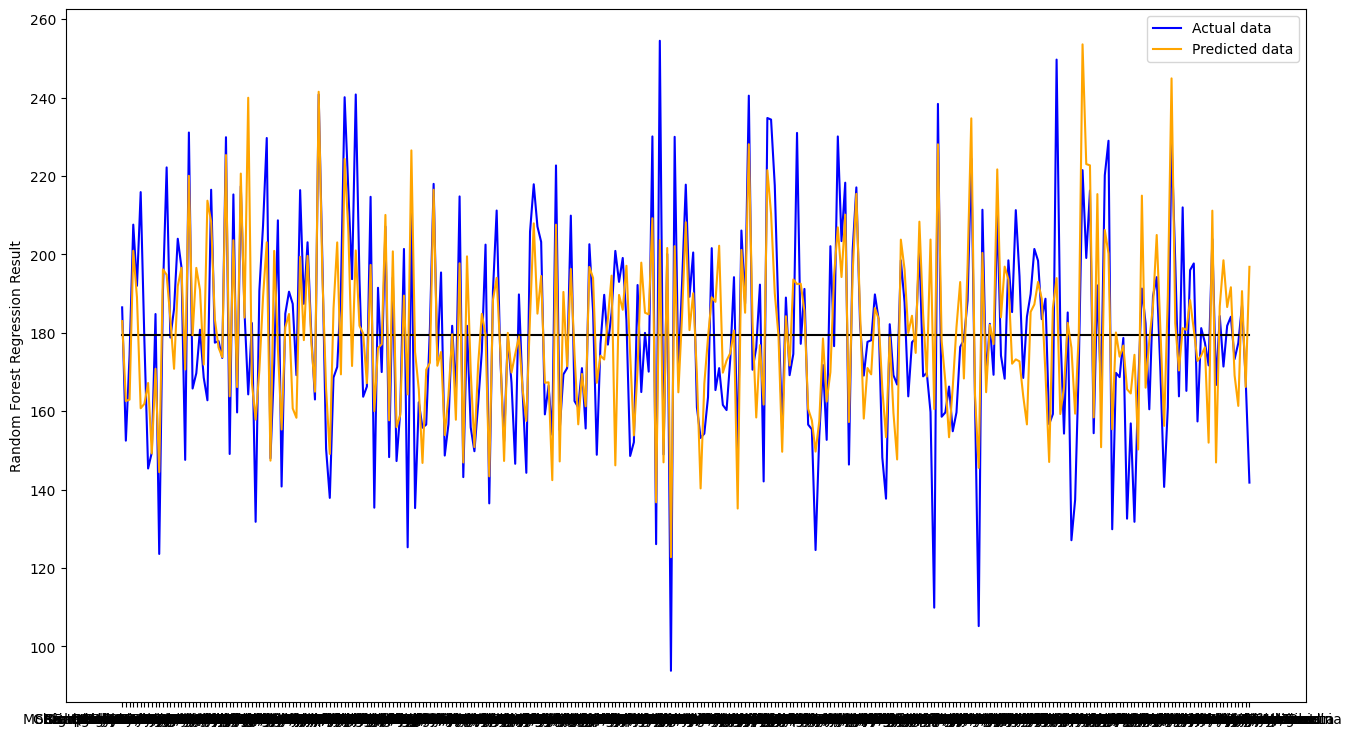

In [49]:
Axis = [y_val.mean()] * len(y_val)
plt.figure(figsize=(16, 9))
plt.ylabel('Random Forest Regression Result')
plt.plot(y_val, 'blue', label='Actual data')
plt.plot(Axis, color="black")
plt.plot(rfr_pred, 'orange', label='Predicted data')
plt.legend()

# XGBoost Regression

https://stackabuse.com/bytes/end-to-end-xgboost-regression-pipeline-with-scikit-learn/

https://xgboost.readthedocs.io/

In [50]:
# pip install xgboost

In [51]:
# xgboost model
from xgboost import XGBRegressor            

In [52]:
def XGBR_Model(trial):
  booster = trial.suggest_categorical('booster', ["gbtree", "gblinear", "dart"])
  grow_policy = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
  gamma = trial.suggest_float("gamma", 0.1, 1.0, step=0.1)
  max_depth = trial.suggest_int("max_depth", 1, 20, step=1)
  n_estimators = trial.suggest_int("max_depth", 500, 3000, step=500)
  learning_rate = trial.suggest_float("learning_rate", 0.1, 1, step=0.1)
  xgbr = XGBRegressor(booster = booster, grow_policy = grow_policy, gamma = gamma, max_depth = max_depth, n_estimators = n_estimators, learning_rate = learning_rate)
  score = sklearn.model_selection.cross_val_score(xgbr, X_train_rfe, y_train, cv=3)
  accuracy = score.mean()
  return accuracy

In [53]:
xgbr_study = optuna.create_study(direction="maximize")
xgbr_study.optimize(XGBR_Model, n_trials=1000)
print(xgbr_study.best_trial)

[I 2023-05-10 01:53:44,231] A new study created in memory with name: no-name-56935398-8925-4b53-a1ee-d9c96c275f09
[I 2023-05-10 01:53:44,715] Trial 0 finished with value: 0.33173508250255757 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.8, 'max_depth': 6, 'learning_rate': 0.9}. Best is trial 0 with value: 0.33173508250255757.
[I 2023-05-10 01:53:44,781] Trial 1 finished with value: -9.99949367945691 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.9, 'max_depth': 1, 'learning_rate': 0.5}. Best is trial 0 with value: 0.33173508250255757.
[I 2023-05-10 01:53:44,842] Trial 2 finished with value: 0.4046625935707844 and parameters: {'booster': 'gblinear', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 7, 'learning_rate': 0.5}. Best is trial 2 with value: 0.4046625935707844.


[01:53:44] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:53:44] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:53:44] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:53:45,075] Trial 3 finished with value: 0.4417865738877162 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.6, 'max_depth': 8, 'learning_rate': 0.5}. Best is trial 3 with value: 0.4417865738877162.
[I 2023-05-10 01:53:45,130] Trial 4 finished with value: 0.38154721839217026 and parameters: {'booster': 'gblinear', 'grow_policy': 'lossguide', 'gamma': 0.9, 'max_depth': 8, 'learning_rate': 0.8}. Best is trial 3 with value: 0.4417865738877162.


[01:53:45] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:53:45] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:53:45] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:53:45,697] Trial 5 finished with value: 0.45453555904969684 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.5, 'max_depth': 15, 'learning_rate': 0.30000000000000004}. Best is trial 5 with value: 0.45453555904969684.
[I 2023-05-10 01:53:46,628] Trial 6 finished with value: 0.4298907609918758 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.9, 'max_depth': 18, 'learning_rate': 0.4}. Best is trial 5 with value: 0.45453555904969684.
[I 2023-05-10 01:53:46,686] Trial 7 finished with value: 0.3948864337288927 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.7000000000000001, 'max_depth': 3, 'learning_rate': 1.0}. Best is trial 5 with value: 0.45453555904969684.
[I 2023-05-10 01:53:47,092] Trial 8 finished with value: 0.32561198989130263 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 13, 'learning_rate': 0.2}. Best is trial 5 with value: 0.4545355

[01:53:47] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:53:47] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:53:47] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:53:47,892] Trial 11 finished with value: 0.31858159113646045 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.5, 'max_depth': 13, 'learning_rate': 0.7000000000000001}. Best is trial 5 with value: 0.45453555904969684.
[I 2023-05-10 01:53:48,340] Trial 12 finished with value: 0.43982778427979907 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.30000000000000004, 'max_depth': 12, 'learning_rate': 0.30000000000000004}. Best is trial 5 with value: 0.45453555904969684.
[I 2023-05-10 01:53:49,195] Trial 13 finished with value: 0.3086145083343863 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.6, 'max_depth': 16, 'learning_rate': 0.7000000000000001}. Best is trial 5 with value: 0.45453555904969684.
[I 2023-05-10 01:53:49,420] Trial 14 finished with value: -4.639021164725803 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.2, 'max_depth': 10, 'learning_rate': 0.1}. Best is t

[01:53:51] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:53:51] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:53:51] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:53:51,914] Trial 20 finished with value: 0.3568635812507647 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.30000000000000004, 'max_depth': 11, 'learning_rate': 0.6}. Best is trial 5 with value: 0.45453555904969684.
[I 2023-05-10 01:53:52,425] Trial 21 finished with value: 0.45740513346248907 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.30000000000000004, 'max_depth': 13, 'learning_rate': 0.30000000000000004}. Best is trial 21 with value: 0.45740513346248907.
[I 2023-05-10 01:53:53,036] Trial 22 finished with value: 0.46465602906399955 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.30000000000000004, 'max_depth': 14, 'learning_rate': 0.4}. Best is trial 22 with value: 0.46465602906399955.
[I 2023-05-10 01:53:53,672] Trial 23 finished with value: 0.4551517816421487 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 14, 'learning_rate': 0.4}. Best 

[01:54:04] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:54:04] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:54:04] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:54:05,225] Trial 36 finished with value: -0.3428902729187797 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.4, 'max_depth': 19, 'learning_rate': 0.1}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:06,052] Trial 37 finished with value: 0.4582847530503831 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.5, 'max_depth': 17, 'learning_rate': 0.30000000000000004}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:06,128] Trial 38 finished with value: 0.4033062224686697 and parameters: {'booster': 'gblinear', 'grow_policy': 'lossguide', 'gamma': 0.4, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.


[01:54:06] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:54:06] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:54:06] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:54:06,594] Trial 39 finished with value: -0.7482918898749041 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.6, 'max_depth': 17, 'learning_rate': 0.1}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:07,976] Trial 40 finished with value: 0.19236599135180313 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.5, 'max_depth': 20, 'learning_rate': 1.0}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:08,996] Trial 41 finished with value: 0.46485066581646234 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 18, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:12,604] Trial 42 finished with value: 0.4675133745875119 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.4, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:

[01:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:54:14] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:54:15,306] Trial 47 finished with value: 0.40017992481912706 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.5, 'max_depth': 17, 'learning_rate': 0.5}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:16,401] Trial 48 finished with value: 0.24646532889154693 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.6, 'max_depth': 19, 'learning_rate': 0.8}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:16,960] Trial 49 finished with value: 0.4140019059147131 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.4, 'max_depth': 15, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:17,117] Trial 50 finished with value: 0.33173508250255757 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.8, 'max_depth': 6, 'learning_rate': 0.9}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01

[01:54:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:54:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:54:26] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:54:26,698] Trial 60 finished with value: -1.359393954541945 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 15, 'learning_rate': 0.1}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:27,511] Trial 61 finished with value: 0.4652568297287654 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.30000000000000004, 'max_depth': 18, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:28,289] Trial 62 finished with value: 0.4645170456043095 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.4, 'max_depth': 18, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:29,044] Trial 63 finished with value: 0.46120338440651726 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.30000000000000004, 'max_depth': 16, 'learning_rate': 0.30000000000000004}. Best is trial 34 with

[01:54:42] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:54:42] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:54:42] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:54:43,111] Trial 77 finished with value: 0.45112930721715533 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 17, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:44,190] Trial 78 finished with value: 0.46377481026608064 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.6, 'max_depth': 20, 'learning_rate': 0.30000000000000004}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:44,961] Trial 79 finished with value: 0.4675133696537195 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:45,595] Trial 80 finished with value: -0.19730965088720906 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.5, 'max_depth': 20, 'learning_rate': 0.1}. Best is trial 34 with value: 0.47283674493071287

[01:54:55] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:54:55] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:54:55] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:54:56,088] Trial 90 finished with value: -0.19416080521220289 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.1}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:56,161] Trial 91 finished with value: -16.45030902913194 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.30000000000000004, 'max_depth': 2, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:57,033] Trial 92 finished with value: 0.46854869874916477 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.30000000000000004, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:54:57,886] Trial 93 finished with value: 0.46854869874916477 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.30000000000000004, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 34 wi

[01:55:23] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:23] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:55:23] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:55:24,744] Trial 118 finished with value: 0.4008942585213708 and parameters: {'booster': 'gbtree', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 20, 'learning_rate': 0.5}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:55:25,610] Trial 119 finished with value: 0.4669557034622612 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.2, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:55:26,230] Trial 120 finished with value: -0.1973065000115178 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 20, 'learning_rate': 0.1}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:55:27,187] Trial 121 finished with value: 0.4707864081959472 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 0.1, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10

[01:56:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:56:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:56:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:56:37,035] Trial 188 finished with value: 0.47283673857756625 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:56:41,012] Trial 189 finished with value: 0.4623927732806446 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 20, 'learning_rate': 0.30000000000000004}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:56:41,294] Trial 190 finished with value: 0.3970865567811488 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 9, 'learning_rate': 0.6}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:56:42,146] Trial 191 finished with value: 0.47283673857756625 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 34 with value: 0.4728367449

[01:57:15] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:57:15] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:57:15] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:57:16,376] Trial 227 finished with value: 0.47283673857756625 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:57:17,161] Trial 228 finished with value: 0.4675133696537195 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:57:17,673] Trial 229 finished with value: -0.3429211626729349 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.5, 'max_depth': 19, 'learning_rate': 0.1}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:57:21,122] Trial 230 finished with value: 0.47283673857756625 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 20

[01:57:41] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:57:41] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:57:41] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:57:42,829] Trial 253 finished with value: 0.47283673857756625 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:57:43,638] Trial 254 finished with value: 0.4675133696537195 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:57:44,469] Trial 255 finished with value: 0.47069467310651225 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.5, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:57:47,785] Trial 256 finished with value: 0.47283673857756625 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 20

[01:58:03] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:58:03] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:58:03] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:58:04,860] Trial 273 finished with value: 0.47283673857756625 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:58:05,710] Trial 274 finished with value: 0.47283673857756625 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:58:06,563] Trial 275 finished with value: 0.47283673857756625 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:58:06,959] Trial 276 finished with value: 0.4249361262218838 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 11, 'learning_rate': 0.5}. Best is trial 34 with value: 0.47283674493071287.
[I 20

[01:58:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:58:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:58:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:58:21,022] Trial 292 finished with value: -0.19858266112940512 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 20, 'learning_rate': 0.1}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:58:21,884] Trial 293 finished with value: 0.47283673857756625 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:58:22,730] Trial 294 finished with value: 0.47283673857756625 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2023-05-10 01:58:23,520] Trial 295 finished with value: 0.4675133696537195 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.4, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 34 with value: 0.47283674493071287.
[I 2

[01:58:38] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:58:38] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[01:58:38] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 01:58:39,202] Trial 312 finished with value: 0.4372867776194705 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.8, 'max_depth': 12, 'learning_rate': 0.30000000000000004}. Best is trial 304 with value: 0.48231129162780406.
[I 2023-05-10 01:58:43,010] Trial 313 finished with value: 0.48231129162780406 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.8, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 304 with value: 0.48231129162780406.
[I 2023-05-10 01:58:43,817] Trial 314 finished with value: 0.46514932225265965 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.8, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 304 with value: 0.48231129162780406.
[I 2023-05-10 01:58:44,376] Trial 315 finished with value: -0.19423884534902194 and parameters: {'booster': 'gbtree', 'grow_policy': 'depthwise', 'gamma': 0.7000000000000001, 'max_depth': 20, 'learning_rate': 0.1}. Best is trial 304 wi

[02:01:32] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:01:32] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:01:32] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:01:34,036] Trial 463 finished with value: 0.46045610039542534 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.30000000000000004}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:01:34,979] Trial 464 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:01:35,876] Trial 465 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:01:36,852] Trial 466 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051

[02:01:57] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:01:57] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:01:57] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:01:58,716] Trial 484 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:01:59,668] Trial 485 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:02:00,942] Trial 486 finished with value: 0.34512149269689135 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.6}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:02:01,374] Trial 487 finished with value: 0.2362239468710495 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 12, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 

[02:02:18] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:02:18] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:02:18] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:02:21,781] Trial 505 finished with value: 0.4074316433739691 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 15, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:02:22,750] Trial 506 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:02:23,709] Trial 507 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:02:24,654] Trial 508 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02

[02:02:45] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:02:45] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:02:45] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:02:49,282] Trial 529 finished with value: 0.4323589739448532 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.4}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:02:50,274] Trial 530 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:02:51,223] Trial 531 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:02:52,205] Trial 532 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02

[02:03:06] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:03:06] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:03:06] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:03:07,285] Trial 547 finished with value: -0.19416080521220289 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.1}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:03:08,258] Trial 548 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:03:09,285] Trial 549 finished with value: 0.46622505724896124 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:03:10,231] Trial 550 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.483001847484205

[02:03:28] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:03:29] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:03:29] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:03:30,422] Trial 568 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:03:31,401] Trial 569 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:03:32,331] Trial 570 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:03:33,310] Trial 571 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 0

[02:03:56] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:03:56] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:03:56] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:03:57,550] Trial 593 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:03:58,530] Trial 594 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:03:59,781] Trial 595 finished with value: 0.23637009348542856 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.9}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:04:00,746] Trial 596 finished with value: 0.47707329493565026 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.7000000000000001, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.

[02:04:15] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:04:15] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:04:15] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:04:15,793] Trial 610 finished with value: -0.19416080521220289 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.1}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:04:16,911] Trial 611 finished with value: 0.46045610039542534 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.30000000000000004}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:04:17,871] Trial 612 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:04:18,769] Trial 613 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.48300184748420

[02:04:39] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:04:39] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:04:39] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:04:40,827] Trial 631 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:04:41,824] Trial 632 finished with value: 0.47860973660290956 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.6, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:04:42,486] Trial 633 finished with value: -0.19416080521220289 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.1}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:04:43,373] Trial 634 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-

[02:05:01] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:05:01] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:05:01] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:05:04,887] Trial 652 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:05:05,804] Trial 653 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:05:06,753] Trial 654 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:05:07,730] Trial 655 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 0

[02:05:25] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:05:25] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:05:25] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:05:26,615] Trial 674 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:05:27,578] Trial 675 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:05:29,303] Trial 676 finished with value: -0.33857772768223987 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.1}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:05:31,597] Trial 677 finished with value: 0.2362239468710495 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 12, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 

[02:05:49] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:05:49] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:05:49] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:05:50,412] Trial 694 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:05:51,387] Trial 695 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:05:52,293] Trial 696 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:05:52,398] Trial 697 finished with value: -25.857281448189266 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.9, 'max_depth': 1, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 0

[02:06:12] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:06:12] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:06:12] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:06:13,813] Trial 715 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:06:14,930] Trial 716 finished with value: 0.46045610039542534 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.30000000000000004}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:06:15,924] Trial 717 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:06:16,825] Trial 718 finished with value: 0.4660882641463843 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.9, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051

[02:06:34] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:06:34] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:06:34] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:06:35,638] Trial 736 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:06:39,667] Trial 737 finished with value: 0.46605626457756216 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.9, 'max_depth': 20, 'learning_rate': 0.30000000000000004}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:06:40,592] Trial 738 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:06:40,938] Trial 739 finished with value: -0.05325573748672915 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 10, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842

[02:06:56] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:06:56] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:06:56] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:06:57,478] Trial 757 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:06:58,451] Trial 758 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:06:59,351] Trial 759 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:07:00,715] Trial 760 finished with value: 0.2029368072107031 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 1.0}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 

[02:07:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:07:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:07:20] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:07:21,789] Trial 778 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:07:22,843] Trial 779 finished with value: 0.46622505724896124 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.30000000000000004}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:07:23,829] Trial 780 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:07:24,735] Trial 781 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051

[02:07:42] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:07:42] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:07:42] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:07:44,790] Trial 799 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:07:47,760] Trial 800 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:07:48,687] Trial 801 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:07:49,589] Trial 802 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 

[02:08:07] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:08:07] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:08:07] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:08:08,850] Trial 820 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:08:09,993] Trial 821 finished with value: 0.46045610039542534 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.30000000000000004}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:08:13,137] Trial 822 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:08:14,903] Trial 823 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051

[02:08:33] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:08:33] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:08:33] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:08:34,618] Trial 841 finished with value: 0.46045610039542534 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.30000000000000004}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:08:35,607] Trial 842 finished with value: 0.48242493273718035 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.9, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:08:36,505] Trial 843 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:08:37,415] Trial 844 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.48300184748420

[02:08:57] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:08:57] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:08:57] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:08:58,078] Trial 861 finished with value: -0.33857772768223987 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.1}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:08:59,088] Trial 862 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:08:59,987] Trial 863 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:09:00,967] Trial 864 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10

[02:09:21] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:09:21] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:09:21] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:09:22,844] Trial 882 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:09:23,826] Trial 883 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'lossguide', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:09:24,509] Trial 884 finished with value: -0.19416080521220289 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.1}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:09:25,422] Trial 885 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10

[02:09:43] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:09:44] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:09:44] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:09:45,071] Trial 903 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:09:49,149] Trial 904 finished with value: 0.4007290797246907 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.5}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:09:50,143] Trial 905 finished with value: 0.48242493273718035 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.9, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:09:51,142] Trial 906 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 0

[02:10:08] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:10:08] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:10:08] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:10:09,340] Trial 924 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:10:10,268] Trial 925 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:10:10,944] Trial 926 finished with value: -0.19416080521220289 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.1}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:10:11,869] Trial 927 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-1

[02:10:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:10:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:10:36] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:10:37,099] Trial 948 finished with value: 0.48242493273718035 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.9, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:10:37,754] Trial 949 finished with value: -0.33857772768223987 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.1}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:10:38,733] Trial 950 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:10:42,773] Trial 951 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10

[02:10:58] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:10:58] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:10:58] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:10:58,954] Trial 966 finished with value: 0.4542246895798661 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 15, 'learning_rate': 0.30000000000000004}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:10:59,945] Trial 967 finished with value: 0.48242493273718035 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 0.9, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:11:00,925] Trial 968 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:11:01,090] Trial 969 finished with value: -6.523393191679866 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 4, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.


[02:11:18] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:11:18] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.

[02:11:18] WARNING: ../src/learner.cc:767: 
Parameters: { "gamma", "grow_policy", "max_depth" } are not used.



[I 2023-05-10 02:11:19,259] Trial 987 finished with value: 0.4529731683041493 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 13, 'learning_rate': 0.30000000000000004}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:11:21,184] Trial 988 finished with value: 0.46996542532917784 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 19, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:11:24,250] Trial 989 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.
[I 2023-05-10 02:11:25,243] Trial 990 finished with value: 0.4830018474842051 and parameters: {'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}. Best is trial 361 with value: 0.4830018474842051.

FrozenTrial(number=361, state=TrialState.COMPLETE, values=[0.4830018474842051], datetime_start=datetime.datetime(2023, 5, 10, 1, 59, 32, 509202), datetime_complete=datetime.datetime(2023, 5, 10, 1, 59, 34, 176426), params={'booster': 'dart', 'grow_policy': 'depthwise', 'gamma': 1.0, 'max_depth': 20, 'learning_rate': 0.2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide')), 'gamma': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1), 'max_depth': IntDistribution(high=20, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=1.0, log=False, low=0.1, step=0.1)}, trial_id=361, value=None)


In [54]:
plot_optimization_history(xgbr_study)

In [55]:
xgbr_study.best_trial.params

{'booster': 'dart',
 'grow_policy': 'depthwise',
 'gamma': 1.0,
 'max_depth': 20,
 'learning_rate': 0.2}

In [56]:
np.save(f"/content/drive/My Drive/DataMining/POC/LungCancer/FeatureSelection/Raw/xgbr_parameter.npy", xgbr_study.best_trial.params)

https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file

In [57]:
xgbr = XGBRegressor(**xgbr_study.best_trial.params)

In [58]:
#training the model
xgbr_model = xgbr.fit(X_train_rfe,y_train) 
xgbr_pred = xgbr_model.predict(X_val_rfe)

## Evaluate

In [59]:
#evaluating the model with the following metrics
#mean squared error
xgbr_mse=mean_squared_error(xgbr_pred, y_val)     
#mean absolute error     
xgbr_mae=mean_absolute_error(xgbr_pred, y_val)  
#root mean squared error      
xgbr_rmse=np.sqrt(mean_squared_error(xgbr_pred, y_val))
#r2 score
xgbr_r2 = r2_score(xgbr_pred, y_val)
print(f'mse: {xgbr_mse}')
print(f'mae: {xgbr_mae}')
print(f'rmse: {xgbr_rmse}')
print(f"r2_score: {xgbr_r2}")

mse: 347.7427560422424
mae: 13.954349550340995
rmse: 18.647861969733754
r2_score: 0.334565887183487


In [60]:
xgbr_df =pd.DataFrame({"mse": xgbr_mse,"mae": xgbr_mae,"rmse": xgbr_rmse,  "r2": xgbr_r2, "deviation": deviation_function(y_val, xgbr_pred)},index=['XGBoost Regression'])

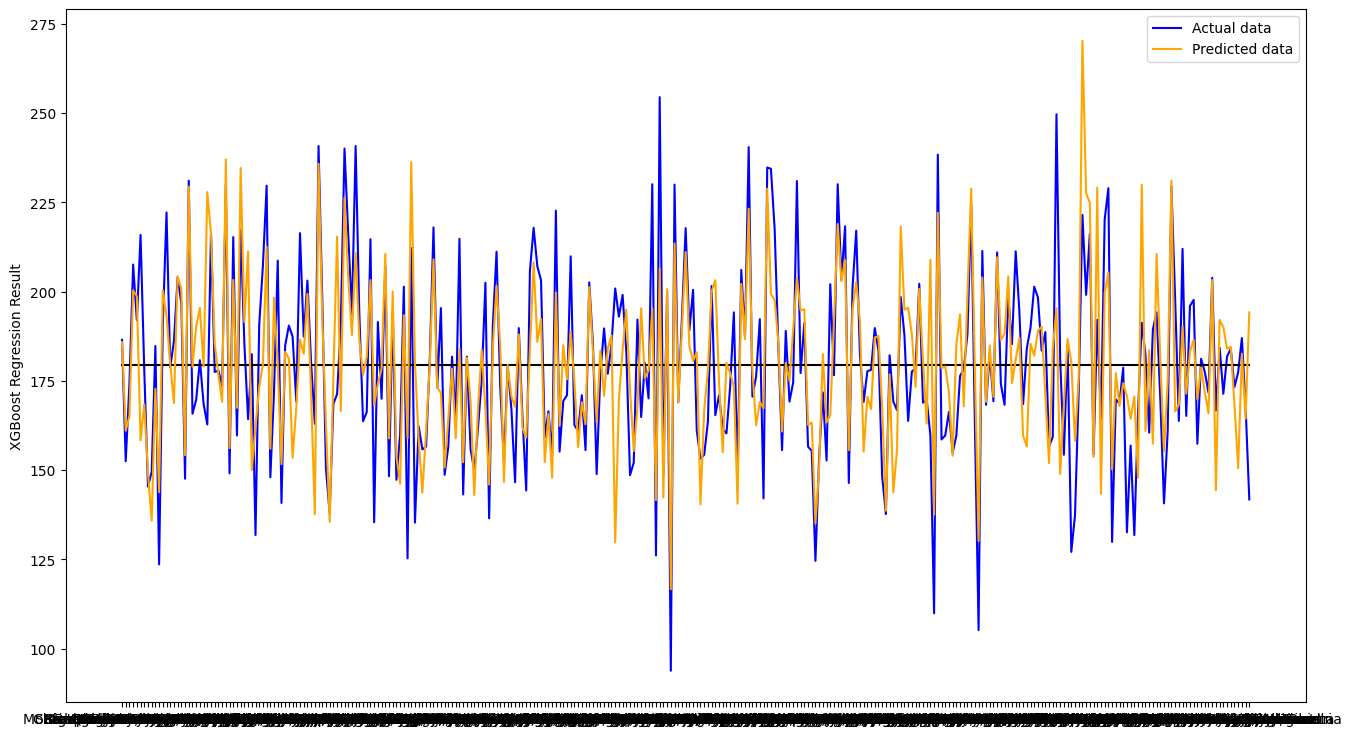

In [61]:
Axis = [y_val.mean()] * len(y_val)
plt.figure(figsize=(16, 9))
plt.ylabel('XGBoost Regression Result')
plt.plot(y_val, 'blue', label='Actual data')
plt.plot(Axis, color="black")
plt.plot(xgbr_pred, 'orange', label='Predicted data')
plt.legend()

# Neural Network

https://stackabuse.com/bytes/end-to-end-xgboost-regression-pipeline-with-scikit-learn/

https://xgboost.readthedocs.io/

In [62]:
# pip install xgboost

In [63]:
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import RobustScaler, normalize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [64]:
def NN_Model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.
    n_layers = trial.suggest_int("n_layers", 1, 6, step = 1)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-3, log=True)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    model = Sequential()
    model.add(Flatten())
    for i in range(n_layers):
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 4096, log=True)
        dropout = trial.suggest_uniform("Dropout_rate", 0.01, 0.80)
        activation = trial.suggest_categorical('activation', ["relu", "tanh", "linear"])
        model.add(
            Dense(
                num_hidden,
                activation=activation,
                kernel_regularizer=tf.keras.regularizers.l2(weight_decay),
            )
        )
        model.add(Dropout(dropout))
    model.add(
        Dense(1, kernel_regularizer=tf.keras.regularizers.l2(weight_decay))
    )
    model.compile(
      loss='mse',
      optimizer=Adam(learning_rate = learning_rate)
    )
    return model

In [65]:
EPOCHS = 30 # number of epocs per trial

def objective(trial):
    keras.backend.clear_session()
    # Generate our trial model.
    model = NN_Model(trial)

    # learning rate scheduler
    scheduler = ExponentialDecay(1e-3, 400*((len(X_train)*0.8)/16), 1e-5)
    lr = LearningRateScheduler(scheduler, verbose=0)

    # Fit the model on the training data.
    # The TFKerasPruningCallback checks for pruning condition every epoch.
    model.fit(
        X_train_rfe, y_train,
        batch_size=16,
        callbacks=[TFKerasPruningCallback(trial, "val_loss")],
        epochs=EPOCHS,
        validation_data=(X_val_rfe, y_val),
        verbose=1,
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(X_val_rfe, y_val, verbose=0)
    return score

In [66]:
nn_study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
nn_study.optimize(objective, n_trials=10)
pruned_trials = nn_study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = nn_study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

[I 2023-05-10 02:11:43,661] A new study created in memory with name: no-name-d7a49115-b731-4b3b-87ec-71b01720393a


Epoch 1/30
155/155 [==============================] - 2s 7ms/step - loss: 18984998912.0000 - val_loss: 25916.3945
Epoch 2/30
155/155 [==============================] - 1s 7ms/step - loss: 20920.1816 - val_loss: 15167.5488
Epoch 3/30
155/155 [==============================] - 1s 10ms/step - loss: 12101.5361 - val_loss: 6573.7700
Epoch 4/30
155/155 [==============================] - 1s 10ms/step - loss: 7486.2041 - val_loss: 3156.4766
Epoch 5/30
155/155 [==============================] - 1s 9ms/step - loss: 6514.3984 - val_loss: 2082.6897
Epoch 6/30
155/155 [==============================] - 1s 7ms/step - loss: 5640.0127 - val_loss: 1858.9001
Epoch 7/30
155/155 [==============================] - 1s 6ms/step - loss: 4960.7876 - val_loss: 1659.5179
Epoch 8/30
155/155 [==============================] - 1s 5ms/step - loss: 4890.6924 - val_loss: 1543.7488
Epoch 9/30
155/155 [==============================] - 1s 6ms/step - loss: 4939.8218 - val_loss: 1478.0040
Epoch 10/30
155/155 [============

[I 2023-05-10 02:12:15,633] Trial 0 finished with value: 31351.10546875 and parameters: {'n_layers': 2, 'weight_decay': 1.8512726421808105e-08, 'learning_rate': 0.07543252853385306, 'n_units_l0': 178, 'Dropout_rate': 0.5039251555941915, 'activation': 'relu', 'n_units_l1': 835}. Best is trial 0 with value: 31351.10546875.


Epoch 1/30
155/155 [==============================] - 1s 4ms/step - loss: 24200.6875 - val_loss: 17791.6465
Epoch 2/30
155/155 [==============================] - 1s 4ms/step - loss: 13481.6855 - val_loss: 10017.0391
Epoch 3/30
155/155 [==============================] - 1s 4ms/step - loss: 7460.8447 - val_loss: 5456.9453
Epoch 4/30
155/155 [==============================] - 1s 4ms/step - loss: 4036.7966 - val_loss: 2929.3660
Epoch 5/30
155/155 [==============================] - 1s 3ms/step - loss: 2232.6616 - val_loss: 1660.9449
Epoch 6/30
155/155 [==============================] - 1s 3ms/step - loss: 1354.5990 - val_loss: 1087.6167
Epoch 7/30
155/155 [==============================] - 1s 4ms/step - loss: 1000.5618 - val_loss: 855.0212
Epoch 8/30
155/155 [==============================] - 1s 4ms/step - loss: 863.8490 - val_loss: 770.8146
Epoch 9/30
155/155 [==============================] - 1s 4ms/step - loss: 816.1116 - val_loss: 743.9706
Epoch 10/30
155/155 [==========================

[I 2023-05-10 02:12:37,190] Trial 1 finished with value: 731.572021484375 and parameters: {'n_layers': 2, 'weight_decay': 8.342071556093589e-05, 'learning_rate': 0.0028505724152412004, 'n_units_l0': 13, 'Dropout_rate': 0.053882430777453576, 'activation': 'tanh', 'n_units_l1': 86}. Best is trial 1 with value: 731.572021484375.


Epoch 1/30
155/155 [==============================] - 13s 77ms/step - loss: 30099.0879 - val_loss: 29452.3379
Epoch 2/30
155/155 [==============================] - ETA: 0s - loss: 28976.8828

[I 2023-05-10 02:13:00,609] Trial 2 pruned. Trial was pruned at epoch 1.


Epoch 1/30
155/155 [==============================] - 2s 4ms/step - loss: 623229696.0000 - val_loss: 4162082.5000
Epoch 2/30
142/155 [==========================>...] - ETA: 0s - loss: 482747584.0000

[I 2023-05-10 02:13:02,893] Trial 3 pruned. Trial was pruned at epoch 1.


Epoch 1/30
155/155 [==============================] - 2s 3ms/step - loss: 30126650.0000 - val_loss: 4896.9678
Epoch 2/30
155/155 [==============================] - 0s 2ms/step - loss: 12940.1074 - val_loss: 4847.3447
Epoch 3/30
155/155 [==============================] - 0s 2ms/step - loss: 13441.9434 - val_loss: 8369.9365
Epoch 4/30
130/155 [========================>.....] - ETA: 0s - loss: 13264.0742

[I 2023-05-10 02:13:05,865] Trial 4 pruned. Trial was pruned at epoch 3.


Epoch 1/30
155/155 [==============================] - 1s 4ms/step - loss: 29092.9395 - val_loss: 27120.1328
Epoch 2/30
155/155 [==============================] - 0s 2ms/step - loss: 25004.2891 - val_loss: 23359.1367
Epoch 3/30
155/155 [==============================] - 0s 3ms/step - loss: 21528.3770 - val_loss: 20032.4844
Epoch 4/30
155/155 [==============================] - 0s 2ms/step - loss: 18431.3672 - val_loss: 17101.3574
Epoch 5/30
155/155 [==============================] - 0s 3ms/step - loss: 15793.4414 - val_loss: 14521.7227
Epoch 6/30
155/155 [==============================] - 0s 2ms/step - loss: 13360.1064 - val_loss: 12262.6084
Epoch 7/30
155/155 [==============================] - 0s 3ms/step - loss: 11350.4473 - val_loss: 10299.0928
Epoch 8/30
155/155 [==============================] - 0s 2ms/step - loss: 9581.0557 - val_loss: 8605.6289
Epoch 9/30
155/155 [==============================] - 0s 2ms/step - loss: 8111.1235 - val_loss: 7143.6460
Epoch 10/30
155/155 [===========

[I 2023-05-10 02:13:19,803] Trial 5 finished with value: 790.5020751953125 and parameters: {'n_layers': 2, 'weight_decay': 7.862156014481701e-05, 'learning_rate': 0.005147856147524438, 'n_units_l0': 84, 'Dropout_rate': 0.39572699841725545, 'activation': 'tanh', 'n_units_l1': 15}. Best is trial 1 with value: 731.572021484375.


Epoch 1/30
155/155 [==============================] - 2s 4ms/step - loss: 4936251904.0000 - val_loss: 112119.3984
Epoch 2/30
155/155 [==============================] - 0s 3ms/step - loss: 1635278848.0000 - val_loss: 181463.1562
Epoch 3/30
155/155 [==============================] - 0s 3ms/step - loss: 839253632.0000 - val_loss: 19442.6816
Epoch 4/30
154/155 [============================>.] - ETA: 0s - loss: 499996160.0000

[I 2023-05-10 02:13:23,321] Trial 6 pruned. Trial was pruned at epoch 3.


Epoch 1/30
155/155 [==============================] - 18s 103ms/step - loss: 417885856.0000 - val_loss: 212270.8281
Epoch 2/30
155/155 [==============================] - 17s 109ms/step - loss: 352419040.0000 - val_loss: 422282.5312
Epoch 3/30
155/155 [==============================] - 15s 99ms/step - loss: 299476736.0000 - val_loss: 679172.1250
Epoch 4/30
155/155 [==============================] - 17s 112ms/step - loss: 300567872.0000 - val_loss: 540465.6875
Epoch 5/30
155/155 [==============================] - 15s 96ms/step - loss: 299340000.0000 - val_loss: 52290.6719
Epoch 6/30
155/155 [==============================] - 15s 97ms/step - loss: 242088464.0000 - val_loss: 205017.3438
Epoch 7/30
155/155 [==============================] - 15s 96ms/step - loss: 275718912.0000 - val_loss: 209316.7969
Epoch 8/30
155/155 [==============================] - 16s 101ms/step - loss: 242375632.0000 - val_loss: 64320.0273
Epoch 9/30
155/155 [==============================] - 17s 109ms/step - loss: 2

[I 2023-05-10 02:21:47,456] Trial 7 finished with value: 11272.017578125 and parameters: {'n_layers': 6, 'weight_decay': 2.5258516638598777e-06, 'learning_rate': 1.01404470159077e-05, 'n_units_l0': 3266, 'Dropout_rate': 0.5299062689842708, 'activation': 'linear', 'n_units_l1': 1363, 'n_units_l2': 62, 'n_units_l3': 658, 'n_units_l4': 1063, 'n_units_l5': 9}. Best is trial 1 with value: 731.572021484375.


Epoch 1/30
155/155 [==============================] - 7s 31ms/step - loss: 41061880.0000 - val_loss: 833.3075
Epoch 2/30
155/155 [==============================] - 3s 21ms/step - loss: 906.9291 - val_loss: 760.9556
Epoch 3/30
155/155 [==============================] - 3s 21ms/step - loss: 904.1001 - val_loss: 757.1295
Epoch 4/30
155/155 [==============================] - 4s 24ms/step - loss: 906.1831 - val_loss: 734.6315
Epoch 5/30
155/155 [==============================] - 5s 30ms/step - loss: 884.6138 - val_loss: 763.8972
Epoch 6/30
155/155 [==============================] - 3s 21ms/step - loss: 897.8999 - val_loss: 802.1867
Epoch 7/30
155/155 [==============================] - 3s 21ms/step - loss: 924.9594 - val_loss: 736.5733
Epoch 8/30
155/155 [==============================] - 3s 22ms/step - loss: 879.8058 - val_loss: 734.7827
Epoch 9/30
155/155 [==============================] - 5s 30ms/step - loss: 918.0535 - val_loss: 745.1641
Epoch 10/30
155/155 [=============================

[I 2023-05-10 02:23:33,761] Trial 8 pruned. Trial was pruned at epoch 27.


Epoch 1/30
155/155 [==============================] - 2s 5ms/step - loss: 7405964.0000 - val_loss: 28713.3867
Epoch 2/30
139/155 [=========================>....] - ETA: 0s - loss: 4157397.7500

[I 2023-05-10 02:24:14,430] Trial 9 pruned. Trial was pruned at epoch 1.


In [67]:
plot_optimization_history(nn_study)

In [68]:
nn_study.best_trial.params

{'n_layers': 2,
 'weight_decay': 8.342071556093589e-05,
 'learning_rate': 0.0028505724152412004,
 'n_units_l0': 13,
 'Dropout_rate': 0.053882430777453576,
 'activation': 'tanh',
 'n_units_l1': 86}

In [69]:
np.save(f"/content/drive/My Drive/DataMining/POC/LungCancer/FeatureSelection/Raw/nn_parameter.npy", nn_study.best_trial.params)

https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file

In [71]:
nn_mod = Sequential()
nn_mod.add(Flatten())
#layer 1
nn_mod.add(
            Dense(
                units = nn_study.best_trial.params['n_units_l0'],
                activation=nn_study.best_trial.params["activation"],
                kernel_regularizer=tf.keras.regularizers.l2(nn_study.best_trial.params["weight_decay"]),
            )
        )
nn_mod.add(Dropout(nn_study.best_trial.params['Dropout_rate']))
#layer 2
nn_mod.add(
            Dense(
                units = nn_study.best_trial.params['n_units_l1'],
                activation=nn_study.best_trial.params["activation"],
                kernel_regularizer=tf.keras.regularizers.l2(nn_study.best_trial.params["weight_decay"]),
            )
        )
nn_mod.add(Dropout(nn_study.best_trial.params['Dropout_rate']))
#output
nn_mod.add(
        Dense(1, kernel_regularizer=tf.keras.regularizers.l2(nn_study.best_trial.params["weight_decay"]))
    )
nn_mod.compile(
      loss='mse',
      optimizer=Adam(learning_rate = nn_study.best_trial.params['learning_rate'])
    )


In [72]:
history = nn_mod.fit(
        X_train_rfe, y_train,
        batch_size=16,
        epochs=EPOCHS,
        validation_data=(X_val_rfe, y_val),
        verbose=1,
    )

Epoch 1/30
155/155 [==============================] - 4s 7ms/step - loss: 24280.5762 - val_loss: 17626.8984
Epoch 2/30
155/155 [==============================] - 1s 5ms/step - loss: 13255.6924 - val_loss: 9777.8262
Epoch 3/30
155/155 [==============================] - 1s 5ms/step - loss: 7249.5801 - val_loss: 5265.5547
Epoch 4/30
155/155 [==============================] - 1s 8ms/step - loss: 3907.2236 - val_loss: 2811.4658
Epoch 5/30
155/155 [==============================] - 1s 7ms/step - loss: 2149.0830 - val_loss: 1592.6444
Epoch 6/30
155/155 [==============================] - 1s 7ms/step - loss: 1318.6089 - val_loss: 1056.7915
Epoch 7/30
155/155 [==============================] - 1s 8ms/step - loss: 988.4116 - val_loss: 841.3314
Epoch 8/30
155/155 [==============================] - 1s 7ms/step - loss: 846.8969 - val_loss: 765.6138
Epoch 9/30
155/155 [==============================] - 1s 6ms/step - loss: 820.2725 - val_loss: 742.3237
Epoch 10/30
155/155 [============================

In [73]:
nn_mod.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 18)                0         
                                                                 
 dense_5 (Dense)             (None, 13)                247       
                                                                 
 dropout_4 (Dropout)         (None, 13)                0         
                                                                 
 dense_6 (Dense)             (None, 86)                1204      
                                                                 
 dropout_5 (Dropout)         (None, 86)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 87        
                                                                 
Total params: 1,538
Trainable params: 1,538
Non-traina

In [74]:
nn_pred = nn_mod.predict(X_val_rfe)

10/10 [==============================] - 0s 2ms/step


## Evaluate

In [75]:
#evaluating the model with the following metrics
#mean squared error
nn_mse=mean_squared_error(nn_pred, y_val)     
#mean absolute error     
nn_mae=mean_absolute_error(nn_pred, y_val)  
#root mean squared error      
nn_rmse=np.sqrt(mean_squared_error(nn_pred, y_val))
#r2 score
nn_r2 = r2_score(nn_pred, y_val)
print(f'mse: {nn_mse}')
print(f'mae: {nn_mae}')
print(f'rmse: {nn_rmse}')
print(f"r2_score: {nn_r2}")

mse: 725.3106921689129
mae: 21.425189419105404
rmse: 26.931592826435516
r2_score: -92.20269151739313


In [76]:
nn_df =pd.DataFrame({"mse": nn_mse,"mae": nn_mae,"rmse": nn_rmse,  "r2": nn_r2, "deviation": deviation_function(y_val, nn_pred)},index=['Neural Network'])

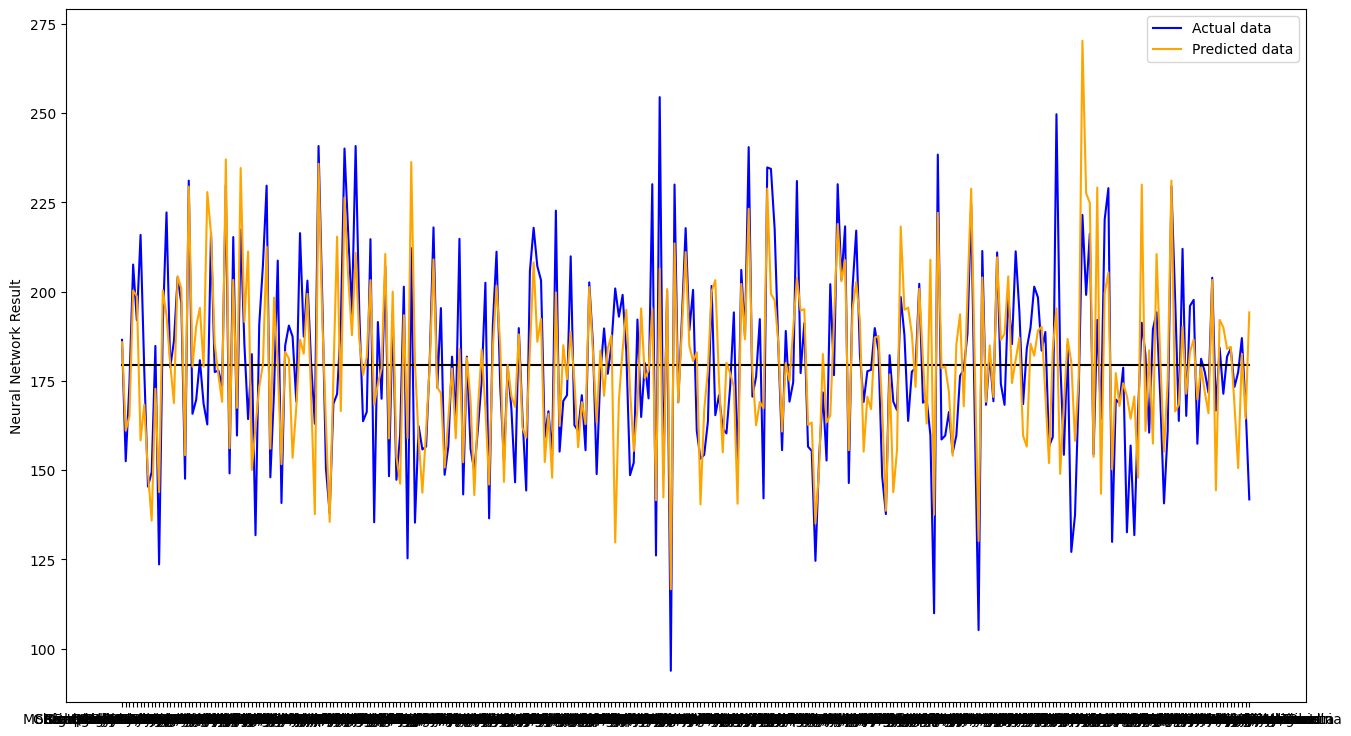

In [77]:
Axis = [y_val.mean()] * len(y_val)
plt.figure(figsize=(16, 9))
plt.ylabel('Neural Network Result')
plt.plot(y_val, 'blue', label='Actual data')
plt.plot(Axis, color="black")
plt.plot(xgbr_pred, 'orange', label='Predicted data')
plt.legend()

# Comparision

https://stats.stackexchange.com/questions/183265/what-does-negative-r-squared-mean#:~:text=It%20means%20you've%20done,least%20squares%20regression%20line%20itself.

https://www.kaggle.com/questions-and-answers/267943

In [78]:
df_evaluation = pd.concat([lr_df, nn_df, dtr_df, rfr_df, xgbr_df]) 
df_evaluation

,mse,mae,rmse,r2,deviation
Linear Regression,333.886574,13.991826,18.272563,0.327839,0.080978
Neural Network,725.310692,21.425189,26.931593,-92.202692,0.123376
Decision Tree Regression,747.080066,20.746885,27.332765,0.134238,0.118710
Random Forest Regression,329.407397,13.777856,18.149584,0.257573,0.079938
XGBoost Regression,347.742756,13.954350,18.647862,0.334566,0.080016


In [79]:
df_evaluation.to_csv("/content/drive/My Drive/DataMining/POC/LungCancer/Evaluation/Raw/optuna.csv")

# Save Model

In [80]:
import pickle
lr_filename = '/content/drive/My Drive/DataMining/POC/LungCancer/Model/Raw/lr_Optuna.h5'
pickle.dump(lr_model, open(lr_filename, 'wb'))
# svr_filename = '/content/drive/My Drive/DataMining/POC/LungCancer/Model/Raw/svr_Optuna.h5'
# pickle.dump(svr_model, open(svr_filename, 'wb'))
rfr_filename = '/content/drive/My Drive/DataMining/POC/LungCancer/Model/Raw/rfr_Optuna.h5'
pickle.dump(rfr_model, open(rfr_filename, 'wb'))
dtr_filename = '/content/drive/My Drive/DataMining/POC/LungCancer/Model/Raw/dtr_Optuna.h5'
pickle.dump(dtr_model, open(dtr_filename, 'wb'))
xgbr_filename = '/content/drive/My Drive/DataMining/POC/LungCancer/Model/Raw/xgbr_Optuna.h5'
pickle.dump(xgbr_model, open(xgbr_filename, 'wb'))
nn_mod.save(f'/content/drive/My Drive/DataMining/POC/LungCancer/Model/Raw/nn_Optuna.h5')